In [1]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import json
import os
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import re
import math

torch.manual_seed(1234)
img2description = dict()

SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant "
    "first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning "
    "process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., "
    "<think> reasoning process here </think><answer> answer here </answer>"
)


def prepare_inputs(img_path, instruction):
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": img_path},
                {"type": "text", "text": f"Output the bounding box in the image corresponding to the instruction: {instruction}. Output the thinking process in <think> </think> and your grouding box. Following \"<think> thinking process </think>\n<answer>(x1,y1),(x2,y2)</answer>)\" format."}
            ]
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, _ = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        padding=True,
        return_tensors="pt",
    )
    return inputs.to("cuda")


model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Zery/Qwen2-VL-7B_visual_rft_lisa_IoU_reward", device_map="auto"
).eval()

processor = AutoProcessor.from_pretrained("Zery/Qwen2-VL-7B_visual_rft_lisa_IoU_reward")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:

image_path = "../assets/pokeymon.jpg"
inputs = prepare_inputs(image_path, "the pokeymon that can perform Thunderbolt. Output thinking process as detail as possibile")

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=128)
response = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(response)

system
A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>
user
Output the bounding box in the image corresponding to the instruction: the pokeymon that can perform Thunderbolt. Output thinking process as detail as possibile. Output the thinking process in <think> </think> and your grouding box. Following "<think> thinking process </think>
<answer>(x1,y1),(x2,y2)</answer>)" format.
assistant
<think> The instruction is to find the bounding box of the Pokémon that can perform Thunderbolt. Thunderbolt is a move that is used by several Pokémon. In the image, there are several Pokémon, including Pikachu, which is known for using Thunderbolt. Pikachu i

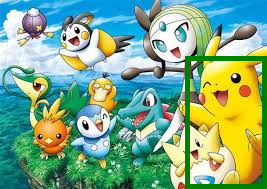

In [5]:
pattern = r"\(\s*(\d+)\s*,\s*(\d+)\s*\)\s*,\s*\(\s*(\d+)\s*,\s*(\d+)\s*\)"
matches = re.findall(pattern, response)
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)
w, h = Image.open(image_path).size
x1, y1, x2, y2 = map(int, matches[0])
box_r1 = [int(x1) / 1000, int(y1) / 1000, int(x2) / 1000, int(y2) / 1000]
draw = ImageDraw.Draw(image)
draw.rectangle([box_r1[0] * w, box_r1[1] * h, box_r1[2] * w, box_r1[3] * h], outline="green", width=5)
image